<a href="https://colab.research.google.com/github/ashimdahal/dogs-vs-cats-keras-kernel-edition/blob/master/dogs_vs_cats_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from cv2 import cv2
import zipfile
import os
import matplotlib.pyplot as plt
import requests

In [24]:
TEST_DIR = 'https://storage.googleapis.com/kagglesdsdata/competitions/5441/38425/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1593959513&Signature=A87mVc7Ji%2FFLAlKaRMyLcEhu%2Fe3gBhqCdtVB2HICK1Zka%2FcMcA8nOLgyAXd7UfmhW%2BQxqzsrBe0ISkaEGiwUDi2IWqpE2f5%2Fjd9tyV3q%2BF8wsWyDlNWuH8ZRytCBAzwk1SFvlQjlc4g0HWVFKFh%2BWe8%2FATiXXbe8JTmgyC2VlKV6I%2BEuxYcX4uqYVakb%2BWLKFVzLD%2F76SLjeBOZcZxYc%2BDETehCETOjuGI6qyshRDqCKcQ6jTCFAbTqlRR4OkRbNTEvguxxhaXBWlj7zmj%2FnCIqO5zP0QqD0y%2FOg7%2B3MHrmXc92qo7wNRCL6bluH2CifAmRX5L1IIMpsBuA2r%2BxVvQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.zip'
TRAIN_DIR = 'https://storage.googleapis.com/kagglesdsdata/competitions/5441/38425/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1593959519&Signature=Ga7uwHkVNVsfqUNf7WV%2FzyaqfUbebvbBPXm7DxTh654G%2FyUdN6uDc6sv%2B1TptbIKFSxxsYfXyNWAE2gQ5pixYKV0m0E6UomzYv5X5CU3ltcq%2Bh8ehG27q7YM1F%2BMRq5E1Q4lHi5a%2F7L1MaVarC1K1X7Xs3qwBSqWYmjsM2ePwyDUUKw6uEg%2FNHlgcTwz95sCZZIxaJqlr%2BEJQk9SU4x%2BcavTmF8zQYVUPYd3ogw%2F%2BUuzmnCp65AQz0WnEBTuSD3UlIiaijWTtPbrW1KQWnibfMuv5HweVDlIXY1WN0hQjaqBLDjK2XHzdVDnGwyUz78IgBvsMuL4YnXlPyLqkj8Tzg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip'

In [25]:
r1 = requests.get(TEST_DIR, allow_redirects=True)
r2 = requests.get(TRAIN_DIR, allow_redirects=True)

In [26]:
!mkdir input

In [27]:
with open('input/train.zip','wb') as f1:
    f1.write(r2.content)
with open('input/test.zip','wb') as f2:
    f2.write(r1.content)

now we extract the images (i have no idea on how to work with elements of zip files without extracting them)

In [28]:
#you can execute this  only once
with zipfile.ZipFile('input/train.zip','r') as trainfile:
    trainfile.extractall()
with zipfile.ZipFile('input/test.zip','r') as trainfile:
    trainfile.extractall()

Now lets see if the files are extracted or not

In [29]:
!ls

input  sample_data  test  train


In [30]:
testdir ='test/'
traindir = 'train/'

now lets get the full path of train images and test images

In [31]:
test_images = [testdir+i for i in os.listdir(testdir)]
all_images = [traindir+i for i in os.listdir(traindir)]

limit = int( 0.8* len(all_images))

train_images = all_images[0:limit]
validation_images = all_images[limit:]

small visualization

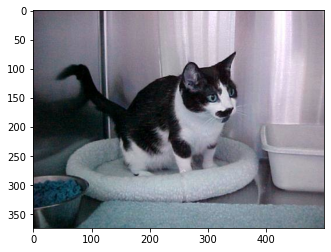

In [32]:
img = cv2.imread(train_images[1])
plt.imshow(img)

lets create a function which will read the image using opencv library

In [33]:
rows, columns = 160,160

In [34]:
def getallimages(path):
    actualdata = np.ndarray((len(path),rows,columns,3),dtype=np.uint8)
    for index , file in enumerate(path):
        img = cv2.imread(file)
        img= cv2.resize(img, (rows, columns), interpolation=cv2.INTER_CUBIC)
#         img = tf.cast(img,tf.float32)
#         img = (img/127.5) - 1
#         img = tf.image.resize(img, (rows, columns))
        actualdata[index] = img
    return actualdata
train = getallimages(train_images)
test = getallimages(test_images)


In [35]:
validation = getallimages(validation_images)

In [36]:
test.shape

(12500, 160, 160, 3)

we need some labels too so lets add y which will be our label 

In [37]:
label = [1 if 'dog' in i else 0 for i in train_images]
validation_label = [1 if 'dog' in i else 0 for i in validation_images]

validation_label[:10]

[1, 0, 1, 0, 0, 1, 1, 1, 0, 1]

In [38]:
image_shape = (rows,rows,3)

In [39]:
type(train)

numpy.ndarray

In [40]:
base_model = tf.keras.applications.ResNet101(
    weights = 'imagenet', include_top=False, input_shape=image_shape)

171450368/171446536 [==============================] - 2s 0us/step


**We freeze the base layer ie its weights are not going to be retraning the model**

In [41]:
base_model.trainable=False

In [42]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [43]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
   
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 5, 5, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 42,660,225
Trainable params: 2,049
Non-trainable params: 42,658,176
_________________________________________________________________


we will create a training batch now


In [45]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train,label))
# validation_ds = tf.data.Dataset.from_tensor_slices((validation,validation_label))

# BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 10000
# validation_batches = validation_ds.batch(BATCH_SIZE)
# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [46]:
base_learning_rate = 0.001
# you can use this tootf.keras.optimizers.RMSprop(learning_rate=base_learning_rate
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
epochs = 3
validation_steps=20

# model.evaluate(validation,validation_label, steps = validation_steps)

In [50]:
model.fit(x=np.array(train),y=np.array(label),validation_data=(np.array(validation),np.array(validation_label)) ,batch_size=128,epochs=epochs,shuffle=True)

Epoch 1/3
157/157 [==============================] - 141s 896ms/step - loss: 0.5135 - accuracy: 0.9801 - val_loss: 0.5122 - val_accuracy: 0.9798
Epoch 2/3
157/157 [==============================] - 141s 896ms/step - loss: 0.5128 - accuracy: 0.9817 - val_loss: 0.5133 - val_accuracy: 0.9744
Epoch 3/3
157/157 [==============================] - 141s 896ms/step - loss: 0.5123 - accuracy: 0.9827 - val_loss: 0.5121 - val_accuracy: 0.9824


In [51]:
prediction  = model.predict_proba(test,verbose=1)

Instructions for updating:
Please use `model.predict()` instead.
391/391 [==============================] - 80s 204ms/step


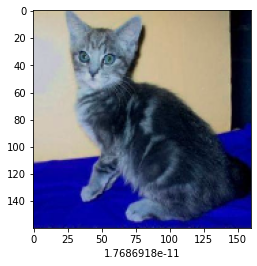

In [52]:
plt.xlabel(prediction[4][0])
plt.imshow(test[4])

In [53]:
# model.save('dgvscat.h5)

In [54]:
 
test_id = [i.split('/')[1][:-4] for i in test_images]

predictions_df = pd.DataFrame({'id': test_id, 'label': prediction[:,0]})
predictions_df
predictions_df.to_csv("submission.csv", index=False,header=True)